VIT + LSTM attention

https://www.analyticsvidhya.com/blog/2021/01/implementation-of-attention-mechanism-for-caption-generation-on-transformers-using-tensorflow/

In [1]:
!pip install -U ipython 

In [2]:
!pip install keras 

In [3]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torchtext

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install inflect

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip  install tensorflow

In [7]:
import json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math

import collections
import random
import numpy as np
import os
from PIL import Image
import time
import re

from torch.nn.utils.rnn import pad_sequence
import torch
import torchvision.models
import torch.nn as nn
from torchvision import transforms
from torchtext.data.metrics import bleu_score
from torch.utils.data import Dataset, DataLoader

#from bpemb import BPEmb
import inflect

%matplotlib inline
from IPython.display import clear_output
import sys, time, os, warnings

In [8]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical
#from keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [9]:
device = 'cuda' if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [10]:
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

Load data

In [11]:
captions_path = "/Users/pc/Desktop/DMML2/Clean-5Sentences_withComma/Clean-5Sentences_withComma.txt"
images_path= "/Users/pc/Desktop/DMML2/Images"
#images_path = "/Users/sayali/Downloads/Images"
jpgs = os.listdir(images_path)

In [12]:
print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 16181


In [13]:
import pandas as pd
# READ THE CAPTIONS FILE.txt
image_df = pd.read_csv(captions_path)

print(f"No of captions: {len(image_df)}")
image_df.head()

No of captions: 40450


,image,caption
0,1000268201_693b08cb0e,गुलाबी पोशाक में बच्चा प्रवेश के रास्ते में सी...
1,1000268201_693b08cb0e,लड़की लकड़ी की इमारत में जा रही है।
2,1000268201_693b08cb0e,छोटी लड़की लकड़ी के प्लेहाउस में चढ़ गई।
3,1000268201_693b08cb0e,छोटी सी लड़की अपने प्लेहाउस में सीढ़ियाँ चढ़ र...
4,1000268201_693b08cb0e,गुलाबी पोशाक में छोटी लड़की लकड़ी के केबिन में...


In [14]:
uni_filenames = np.unique(image_df.image.values)

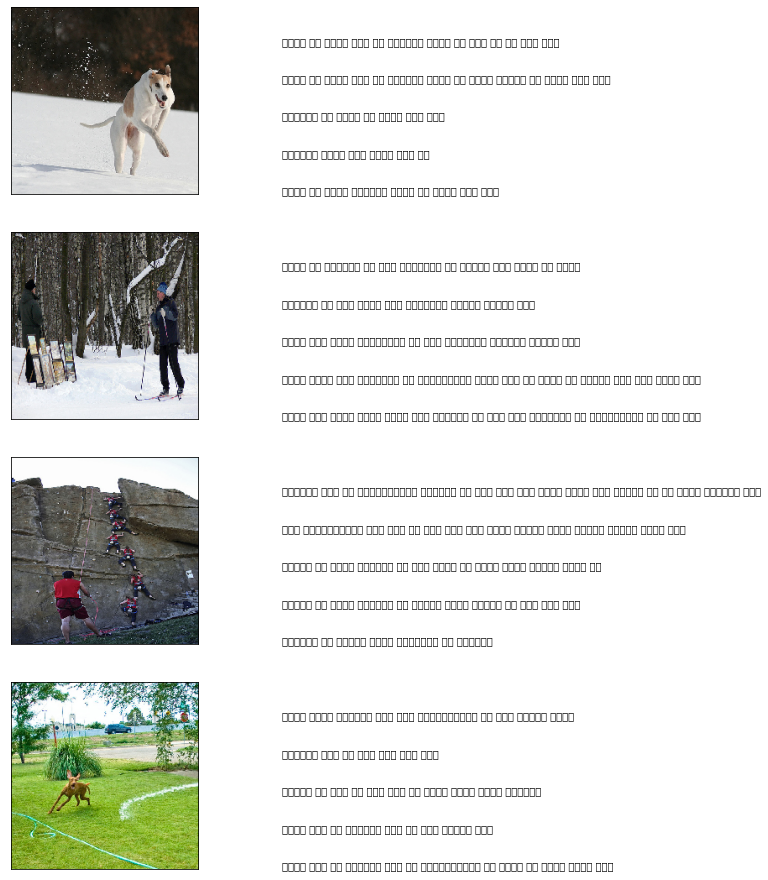

In [15]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
   filename1 = images_path + '/' + jpgfnm + '.jpg'
   captions = list(image_df["caption"].loc[image_df["image"]==jpgfnm].values)
   image_load = load_img(filename1, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption)
   count += 1
plt.show()

In [16]:
#Next let’s see what our current vocabulary size is:-
vocabulary = []
for txt in image_df.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 10447


In [17]:
#We also add ‘< start >’ and ‘< end >’ tags to every caption so that the model understands the starting and end of each caption.

all_captions = []
for caption  in image_df["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

['<start> गुलाबी पोशाक में बच्चा प्रवेश के रास्ते में सीढ़ियों के सेट पर चढ़ रहा है। <end>',
 '<start> लड़की लकड़ी की इमारत में जा रही है। <end>',
 '<start> छोटी लड़की लकड़ी के प्लेहाउस में चढ़ गई। <end>',
 '<start> छोटी सी लड़की अपने प्लेहाउस में सीढ़ियाँ चढ़ रही थी। <end>',
 '<start> गुलाबी पोशाक में छोटी लड़की लकड़ी के केबिन में जा रही है। <end>',
 '<start> काला कुत्ता और चित्तीदार कुत्ता लड़ रहे हैं <end>',
 '<start> काला कुत्ता और सड़क पर दूसरे के साथ खेलता हुआ तिरंगा कुत्ता। <end>',
 '<start> काले कुत्ते और भूरे रंग के धब्बे वाला सफेद कुत्ता सड़क पर दूसरे को घूर रहा है। <end>',
 '<start> सड़क पर एक-दूसरे को देख अलग-अलग नस्लों के कुत्ते। <end>',
 '<start> फुटपाथ पर कुत्ते दूसरे की ओर बढ़ते हुए। <end>']

In [18]:
all_img_name_vector = []
for annot in image_df["image"]:
   full_image_path = images_path + '/' + annot + '.jpg'
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['/Users/pc/Desktop/DMML2/Images/1000268201_693b08cb0e.jpg',
 '/Users/pc/Desktop/DMML2/Images/1000268201_693b08cb0e.jpg',
 '/Users/pc/Desktop/DMML2/Images/1000268201_693b08cb0e.jpg',
 '/Users/pc/Desktop/DMML2/Images/1000268201_693b08cb0e.jpg',
 '/Users/pc/Desktop/DMML2/Images/1000268201_693b08cb0e.jpg',
 '/Users/pc/Desktop/DMML2/Images/1001773457_577c3a7d70.jpg',
 '/Users/pc/Desktop/DMML2/Images/1001773457_577c3a7d70.jpg',
 '/Users/pc/Desktop/DMML2/Images/1001773457_577c3a7d70.jpg',
 '/Users/pc/Desktop/DMML2/Images/1001773457_577c3a7d70.jpg',
 '/Users/pc/Desktop/DMML2/Images/1001773457_577c3a7d70.jpg']

In [19]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")
#total_captions = {len(all_captions)}

len(all_img_name_vector) : 40450
len(all_captions) : 40450


We will take only 40000 of each so that we can select batch size properly i.e. 625 batches if batch size= 64. To do this we define a function to limit the dataset to 40000 images and captions.

In [20]:
def data_limiter(num,total_captions,all_img_name_vector):
   train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
   train_captions = train_captions[:num]
   img_name_vector = img_name_vector[:num]
   return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)


In [21]:
len(img_name_vector)

40000

Let’s define the image feature extraction model using InceptionV3. We must remember that we do not need to classify the images here, we only need to extract an image vector for our images. Hence we remove the softmax layer from the model. We must all preprocess all the images to the same size, i.e, 299×299 before feeding them into the model, and the shape of the output of this layer is 8x8x2048.

In [22]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (299, 299))
   img = tf.keras.applications.inception_v3.preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

Next, let’s Map each image name to the function to load the image. We will pre-process each image with InceptionV3 and cache the output to disk and image features are reshaped to 64×2048.

In [23]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [24]:
len(image_dataset)
#for element in image_dataset.as_numpy_iterator():
#  print(element)

127

We extract the features and store them in the respective .npy files and then pass those features through the encoder.NPY files store all the information required to reconstruct an array on any computer, which includes dtype and shape information.

In [25]:
PATH = "/Users/pc/Desktop/DMML2/Images"
i = 1
for img, path in tqdm(image_dataset):
   batch_features = image_features_extract_model(img)
   batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

   for bf, p in zip(batch_features, path):
     path_of_feature = p.numpy().decode("utf-8")
     np.save(path_of_feature, bf.numpy())

print(i)

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [25:06<00:00, 11.87s/it]

1


In [26]:
print = 'hello'
np.load('/content/gdrive/MyDrive/Images/96985174_31d4c6f06d.jpg.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/Images/96985174_31d4c6f06d.jpg.npy'

we tokenize the captions and build a vocabulary of all the unique words in the data.

In [27]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

Next, Create training and validation sets using an 80-20 split:



In [28]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)


Next, let’s create a tf.data dataset to use for training our model

In [29]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE
#print(num_steps)

def map_func(img_name, cap):
   #print(img_name)
   img_name_new = img_name
   #img_name_new = img_name.replace(".jpg", "")
   #print(img_name_new)
   img_tensor = np.load(img_name.decode('utf-8') +'.npy')  #p.numpy().decode("utf-8")
   return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

The positional encoding uses sine and cosine functions of different frequencies. For every odd index on the input vector, create a vector using the cos function, for every even index, create a vector using the sin function. Then add those vectors to their corresponding input embeddings which successfully gives the network information on the position of each vector.

In [30]:
def get_angles(pos, i, d_model):
   angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
   return pos * angle_rates

def positional_encoding_1d(position, d_model):
   angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)

   angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
   angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
   pos_encoding = angle_rads[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32)

def positional_encoding_2d(row,col,d_model):
   assert d_model % 2 == 0
   row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
   col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)

   angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
   angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

   angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
   angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
   angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
   angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
   pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32)

Step 5:- Multi-Head Attention
Calculate the attention weights. q, k, v must have matching leading dimensions. k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v. The mask has different shapes depending on its type (padding or look ahead) but it must be broadcastable for addition

In [31]:
def create_padding_mask(seq):
   seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
   return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
   mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
   return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
   matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
   dk = tf.cast(tf.shape(k)[-1], tf.float32)
   scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

   if mask is not None:
      scaled_attention_logits += (mask * -1e9) 

   attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
   output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

   return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads):
      super(MultiHeadAttention, self).__init__()
      self.num_heads = num_heads
      self.d_model = d_model
      assert d_model % self.num_heads == 0
      self.depth = d_model // self.num_heads
      self.wq = tf.keras.layers.Dense(d_model)
      self.wk = tf.keras.layers.Dense(d_model)
      self.wv = tf.keras.layers.Dense(d_model)
      self.dense = tf.keras.layers.Dense(d_model)

   def split_heads(self, x, batch_size):
      x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
      return tf.transpose(x, perm=[0, 2, 1, 3])

   def call(self, v, k, q, mask=None):
      batch_size = tf.shape(q)[0]
      q = self.wq(q)  # (batch_size, seq_len, d_model)
      k = self.wk(k)  # (batch_size, seq_len, d_model)
      v = self.wv(v)  # (batch_size, seq_len, d_model)

      q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
      k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
      v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

      scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
      scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

      concat_attention = tf.reshape(scaled_attention,
                                 (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

      output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
      return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
   return tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                tf.keras.layers.Dense(d_model)])  # (batch_size, seq_len, d_model)])



Step 6:- Encoder-Decoder Layer


In [32]:
class EncoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(EncoderLayer, self).__init__()
      self.mha = MultiHeadAttention(d_model, num_heads)
      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)


   def call(self, x, training, mask=None):
      attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
      attn_output = self.dropout1(attn_output, training=training)
      out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

      ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
      ffn_output = self.dropout2(ffn_output, training=training)
      out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
      return out2

In [33]:
class DecoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(DecoderLayer, self).__init__()
      self.mha1 = MultiHeadAttention(d_model, num_heads)
      self.mha2 = MultiHeadAttention(d_model, num_heads)

      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)
      self.dropout3 = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
      attn1 = self.dropout1(attn1, training=training)
      out1 = self.layernorm1(attn1 + x)

      attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
      attn2 = self.dropout2(attn2, training=training)
      out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

      ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
      ffn_output = self.dropout3(ffn_output, training=training)
      out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

      return out3, attn_weights_block1, attn_weights_block2

In [34]:
class Encoder(tf.keras.layers.Layer):
   def __init__(self, num_layers, d_model, num_heads, dff, row_size,col_size,rate=0.1):
      super(Encoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
      self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model)

      self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, training, mask=None):
      seq_len = tf.shape(x)[1]
      x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x = self.enc_layers[i](x, training, mask)

      return x  # (batch_size, input_seq_len, d_model)

In [35]:
class Decoder(tf.keras.layers.Layer):
   def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding,   rate=0.1):
      super(Decoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
      self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

      self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      seq_len = tf.shape(x)[1]
      attention_weights = {}

      x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)
         
         attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
         attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

      return x, attention_weights

Step 7:- Transformer 


In [36]:
class Transformer(tf.keras.Model):
   def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
              target_vocab_size,max_pos_encoding, rate=0.1):
      super(Transformer, self).__init__()
      self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)
      self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                          target_vocab_size,max_pos_encoding, rate)
      self.final_layer = tf.keras.layers.Dense(target_vocab_size)

   def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None   ):
      enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model      )
      dec_output, attention_weights = self.decoder(
      tar, enc_output, training, look_ahead_mask, dec_padding_mask)
      final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
      return final_output, attention_weights

Step 8:- Model Hyperparameters


In [37]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1 


In [38]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
   def __init__(self, d_model, warmup_steps=4000):
      super(CustomSchedule, self).__init__()
      self.d_model = d_model
      self.d_model = tf.cast(self.d_model, tf.float32)
      self.warmup_steps = warmup_steps

   def __call__(self, step):
      arg1 = tf.math.rsqrt(step)
      arg2 = step * (self.warmup_steps ** -1.5)
      return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [39]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
   mask = tf.math.logical_not(tf.math.equal(real, 0))
   loss_ = loss_object(real, pred)
   mask = tf.cast(mask, dtype=loss_.dtype)
   loss_ *= mask
   return tf.reduce_sum(loss_)/tf.reduce_sum(mask) 

In [40]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size, max_pos_encoding=target_vocab_size,rate=dropout_rate)

Step 9:- Model Training

In [41]:
def create_masks_decoder(tar):
   look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
   dec_target_padding_mask = create_padding_mask(tar)
   combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
   return combined_mask

In [42]:
@tf.function
def train_step(img_tensor, tar):
   tar_inp = tar[:, :-1]
   tar_real = tar[:, 1:]
   dec_mask = create_masks_decoder(tar_inp)
   with tf.GradientTape() as tape:
      predictions, _ = transformer(img_tensor, tar_inp,True, dec_mask)
      loss = loss_function(tar_real, predictions)

   gradients = tape.gradient(loss, transformer.trainable_variables)   
   optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
   train_loss(loss)
   train_accuracy(tar_real, predictions)

In [45]:
for epoch in range(1):
   start = time.time()
   train_loss.reset_states()
   train_accuracy.reset_states()
   for (batch, (img_tensor, tar)) in enumerate(dataset):
      train_step(img_tensor, tar)
      #if batch % 50 == 0:
         #print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, train_loss.result(), train_accuracy.result()))
         #print(epoch + 1, batch, train_loss.result(), train_accuracy.result())
   #print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               #train_loss.result(),
                                              # train_accuracy.result()))
   #print(epoch + 1,train_loss.result(),train_accuracy.result())
   #print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
   #print((time.time() - start))

In [53]:
print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
train_accuracy.result()

TypeError: 'str' object is not callable

Step 10:- BLEU Evaluation

In [54]:
text1 = "Hello, "

text2 = " Welcome"

print(str(text1 + text2))

TypeError: 'str' object is not callable

In [ ]:
def evaluate(image):
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   start_token = tokenizer.word_index['<start>']
   end_token = tokenizer.word_index['<end>']
   decoder_input = [start_token]
   output = tf.expand_dims(decoder_input, 0) #tokens
   result = [] #word list

   for i in range(100):
      dec_mask = create_masks_decoder(output)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      if predicted_id == end_token:
         return result,tf.squeeze(output, axis=0), attention_weights
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

   return result,tf.squeeze(output, axis=0), attention_weights


In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
   if i=="<unk>":
      caption.remove(i)

for i in real_caption:
   if i=="<unk>":
      real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
score*100
score1 = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
score1*100
score2 = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
score2*100
score3 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
score3*100
real_caption
caption
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


In [ ]:
caption

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
   if i=="<unk>":
      caption.remove(i)

for i in real_caption:
   if i=="<unk>":
      real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score4 = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
score4
score5 = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
score5
score6 = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
score6
score7 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
score7
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

In [ ]:
caption

END